# M1L2 Screencasts

## M1L2SC1: From GANs to Autoregressive Models: Hands-On with Generative Basics

### Step 1: Setting Up Our Environment

In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np
# Import additional model-specific libraries
from torch import nn, optim

### Step 2: Defining the GAN Framework

In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.hidden_layer = nn.Linear(100, 256)
        self.output_layer = nn.Linear(256, 784)

    def forward(self, x):
        x = torch.relu(self.hidden_layer(x))
        x = torch.tanh(self.output_layer(x))
        return x

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.hidden_layer = nn.Linear(784, 256)
        self.output_layer = nn.Linear(256, 1)

    def forward(self, x):
        x = torch.relu(self.hidden_layer(x))
        x = torch.sigmoid(self.output_layer(x))
        return x

### Step 3: Training the GAN

In [ ]:
generator = Generator()
discriminator = Discriminator()

# Optimizers and Loss function
optimizer_g = optim.Adam(generator.parameters(), lr=0.0002)
optimizer_d = optim.Adam(discriminator.parameters(), lr=0.0002)
criterion = nn.BCELoss()
batch_size = 32 # added batch size to avoid errors later

for epoch in range(100):
    # Generate fake data
    noise = torch.randn(batch_size, 100)
    fake_data = generator(noise)

    # Train Discriminator
    # Here the assumption is that the real data comes from a uniform distribution between -1 and 1, same as the output of the Generator
    real_data = torch.rand(batch_size, 784) * 2 - 1  # Load real data here
    optimizer_d.zero_grad()
    real_loss = criterion(discriminator(real_data), torch.ones(batch_size, 1))
    fake_loss = criterion(discriminator(fake_data.detach()), torch.zeros(batch_size, 1))
    d_loss = real_loss + fake_loss
    d_loss.backward()
    optimizer_d.step()

    # Train Generator
    optimizer_g.zero_grad()
    g_loss = criterion(discriminator(fake_data), torch.ones(batch_size, 1))
    g_loss.backward()
    optimizer_g.step()

    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Discriminator Loss: {d_loss.item()}, Generator Loss: {g_loss.item()}')

Epoch 0, Discriminator Loss: 1.3984835147857666, Generator Loss: 0.7183547616004944
Epoch 10, Discriminator Loss: 1.3606584072113037, Generator Loss: 0.7044712901115417
Epoch 20, Discriminator Loss: 1.3490543365478516, Generator Loss: 0.6951377391815186
Epoch 30, Discriminator Loss: 1.314748764038086, Generator Loss: 0.7356384992599487
Epoch 40, Discriminator Loss: 1.264267921447754, Generator Loss: 0.7688094973564148
Epoch 50, Discriminator Loss: 1.2897406816482544, Generator Loss: 0.7516092658042908
Epoch 60, Discriminator Loss: 1.2764275074005127, Generator Loss: 0.7318829298019409
Epoch 70, Discriminator Loss: 1.168318748474121, Generator Loss: 0.8158411979675293
Epoch 80, Discriminator Loss: 1.143221378326416, Generator Loss: 0.9094999432563782
Epoch 90, Discriminator Loss: 1.0687243938446045, Generator Loss: 0.9843035936355591


### Step 4: Creating the VAE Framework

In [ ]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        self.encoder_hidden = nn.Linear(784, 256)
        self.mean_layer = nn.Linear(256, 20)
        self.log_var_layer = nn.Linear(256, 20)
        self.decoder_hidden = nn.Linear(20, 256)
        self.output_layer = nn.Linear(256, 784)

    def encode(self, x):
        h = torch.relu(self.encoder_hidden(x))
        return self.mean_layer(h), self.log_var_layer(h)

    def decode(self, z):
        h = torch.relu(self.decoder_hidden(z))
        return torch.sigmoid(self.output_layer(h))

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        return self.decode(z), mu, log_var

### Step 5: Training the VAE

In [ ]:
def loss_function(recon_x, x, mu, log_var):
    BCE = nn.functional.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return BCE + KLD

vae = VAE()
optimizer = optim.Adam(vae.parameters(), lr=0.001)

for epoch in range(100):
    vae.train()
    x = torch.rand(batch_size, 784)  # Load batch of data here
    optimizer.zero_grad()
    recon_x, mu, log_var = vae(x)
    loss = loss_function(recon_x, x, mu, log_var)
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')

Epoch 0, Loss: 17608.359375
Epoch 10, Loss: 17497.1953125
Epoch 20, Loss: 17482.26953125
Epoch 30, Loss: 17454.814453125
Epoch 40, Loss: 17457.11328125
Epoch 50, Loss: 17459.384765625
Epoch 60, Loss: 17450.53515625
Epoch 70, Loss: 17441.46875
Epoch 80, Loss: 17437.892578125
Epoch 90, Loss: 17433.791015625


### Step 6: Analyzing Sequence Prediction

In [ ]:
# Assume existing sequence data prep
sequence_length = 5
batch_size = 10
input_size = 10
hidden_size = 20
num_layers = 2
vocab_size = 10  # Made up number for dummy data

sequence_data = torch.randn(batch_size, sequence_length, input_size) # (B, Seq, Input)

model = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers)

# Target needs to be *class indices* (long integers)!
sequence_data_target = torch.randint(0, vocab_size, (batch_size, sequence_length)).long() # (B, Seq)

def train_autoregressive(sequence_data):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    for epoch in range(50):
        model.train()
        optimizer.zero_grad()

        output, _ = model(sequence_data)  # LSTM outputs (batch, seq_len, hidden_size)

        # Reshape:  (B, Seq, Hidden) -> (B*Seq, Hidden) to match CrossEntropyLoss
        loss = criterion(output.reshape(-1, hidden_size), sequence_data_target.reshape(-1))
        loss.backward()
        optimizer.step()

        if epoch % 10 == 0:
            print(f'Epoch {epoch}, Loss: {loss.item()}')

train_autoregressive(sequence_data)

Epoch 0, Loss: 2.977612018585205
Epoch 10, Loss: 2.5618903636932373
Epoch 20, Loss: 2.309968948364258
Epoch 30, Loss: 2.2219197750091553
Epoch 40, Loss: 2.134457588195801


## M1L2SC2: Diffusion Models in Action: From Noise to Realistic Outputs

### Step 1: Setting Up the Environment

Device: cpu


100%|██████████| 26.4M/26.4M [00:01<00:00, 17.8MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 275kB/s]
100%|██████████| 4.42M/4.42M [00:00<00:00, 4.95MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 22.4MB/s]


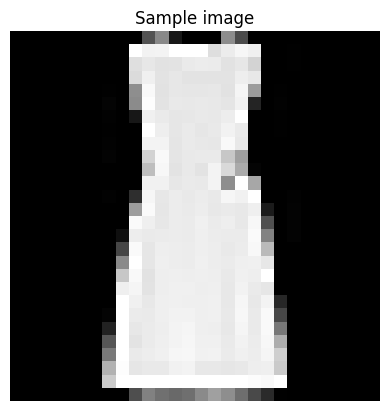

In [ ]:
import math
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

import torch
from torch import nn, optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms

import warnings
warnings.filterwarnings('ignore')

# Use GPUs, if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device: {device}')

# Hyper‑parameters (tweak here)
EPOCHS = 5        # training epochs for VAE & cGAN
BATCH_SIZE = 128
LR = 2e-4     # learning rate for all optimizers
DDPM_STEPS = 100      # diffusion timesteps
SIGMA_NOISE = 0.5      # std‑dev of added Gaussian noise

# Data: Fashion‑MNIST train/validation split
transform = transforms.ToTensor()
dataset = datasets.FashionMNIST(root='data', download=True, transform=transform)
train_len = int(0.9 * len(dataset))
ds_train, ds_val = random_split(dataset, [train_len, len(dataset) - train_len])
train_loader = DataLoader(ds_train, batch_size=BATCH_SIZE, shuffle=True,  num_workers=2)
val_loader = DataLoader(ds_val,   batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

# quick sanity‑check image
img0, _ = ds_val[0]
plt.imshow(img0.squeeze(), cmap='gray')
plt.title('Sample image')
plt.axis('off')
plt.show()

### Step 2: Define Utility Functions

In [ ]:
def add_noise(x, sigma=SIGMA_NOISE):
    """Add i.i.d. Gaussian noise and clip to [0, 1]."""
    return (x + sigma * torch.randn_like(x)).clamp(0, 1)

@torch.no_grad()
def mse_on_loader(model, loader, method: str):
    """Mean‑squared error between denoised outputs and clean images."""
    model.eval()
    mse, n = 0.0, 0
    for x_clean, _ in loader:
        x_clean = x_clean.to(device)
        x_noisy = add_noise(x_clean)
        if method == 'vae':
            out, _, _ = model(x_noisy)
        elif method == 'gan':
            out = model(x_noisy)
        else:  # diffusion
            out = model.denoise(x_noisy)
        mse += nn.MSELoss(reduction='sum')(out, x_clean).item()
        n   += x_clean.size(0)
    return mse / n

### Step 3: Implementing Variational Auto-Encoder (VAE)




In [ ]:
class VAE(nn.Module):
    def __init__(self, z_dim=64):
        super().__init__()
        self.enc = nn.Sequential(
            nn.Flatten(), nn.Linear(28*28, 400), nn.ReLU()
        )
        self.fc_mu    = nn.Linear(400, z_dim)
        self.fc_logvar= nn.Linear(400, z_dim)
        self.dec = nn.Sequential(
            nn.Linear(z_dim, 400), nn.ReLU(), nn.Linear(400, 28*28), nn.Sigmoid()
        )

    def encode(self, x):
        h = self.enc(x)
        return self.fc_mu(h), self.fc_logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        return self.dec(z).view(-1,1,28,28)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z  = self.reparameterize(mu, logvar)
        recon = self.decode(z)
        return recon, mu, logvar

vae = VAE().to(device)
opt_vae = optim.Adam(vae.parameters(), lr=LR)

for epoch in range(EPOCHS):
    vae.train()
    pbar = tqdm(train_loader, desc=f'VAE epoch {epoch+1}/{EPOCHS}')
    for x, _ in pbar:
        x = x.to(device)
        x_noisy = add_noise(x)
        recon, mu, logvar = vae(x_noisy)
        recon_loss = nn.functional.mse_loss(recon, x, reduction='sum') / x.size(0)
        kl = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) / x.size(0)
        loss = recon_loss + kl
        opt_vae.zero_grad(); loss.backward(); opt_vae.step()
        pbar.set_postfix({'loss': f'{loss.item():.3f}'})

print('VAE training done.')

VAE epoch 1/5:   0%|          | 0/422 [00:00<?, ?it/s]

VAE epoch 2/5:   0%|          | 0/422 [00:00<?, ?it/s]

VAE epoch 3/5:   0%|          | 0/422 [00:00<?, ?it/s]

VAE epoch 4/5:   0%|          | 0/422 [00:00<?, ?it/s]

VAE epoch 5/5:   0%|          | 0/422 [00:00<?, ?it/s]

VAE training done.


### Step 4: Generative Adversarial Network (GAN)

In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1,32,3,padding=1), nn.ReLU(),
            nn.Conv2d(32,32,3,padding=1), nn.ReLU(),
            nn.Conv2d(32,1,3,padding=1), nn.Sigmoid(),
        )
    def forward(self,x):
        return self.net(x)

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1,32,4,2,1), nn.LeakyReLU(0.2),
            nn.Conv2d(32,64,4,2,1), nn.LeakyReLU(0.2),
            nn.Flatten(), nn.Linear(7*7*64,1), nn.Sigmoid(),
        )
    def forward(self,x):
        return self.net(x)

gen = Generator().to(device)
disc= Discriminator().to(device)
opt_G = optim.Adam(gen.parameters(), lr=LR)
opt_D = optim.Adam(disc.parameters(), lr=LR)
criterion = nn.BCELoss()

for epoch in range(EPOCHS):
    pbar = tqdm(train_loader, desc=f'cGAN epoch {epoch+1}/{EPOCHS}')
    for x, _ in pbar:
        x = x.to(device)
        x_noisy = add_noise(x)
        # ---- Discriminator ----
        disc.zero_grad()
        real_out = disc(x)
        fake_img = gen(x_noisy).detach()
        fake_out = disc(fake_img)
        loss_D = (criterion(real_out, torch.ones_like(real_out)) +
                  criterion(fake_out, torch.zeros_like(fake_out))) / 2
        loss_D.backward(); opt_D.step()
        # ---- Generator ----
        gen.zero_grad()
        gen_img = gen(x_noisy)
        out = disc(gen_img)
        loss_G = criterion(out, torch.ones_like(out)) + nn.functional.mse_loss(gen_img, x)
        loss_G.backward(); opt_G.step()
        pbar.set_postfix({'loss_G': f'{loss_G.item():.3f}'})

print('cGAN training done.')

cGAN epoch 1/5:   0%|          | 0/422 [00:00<?, ?it/s]

cGAN epoch 2/5:   0%|          | 0/422 [00:00<?, ?it/s]

cGAN epoch 3/5:   0%|          | 0/422 [00:00<?, ?it/s]

cGAN epoch 4/5:   0%|          | 0/422 [00:00<?, ?it/s]

cGAN epoch 5/5:   0%|          | 0/422 [00:00<?, ?it/s]

cGAN training done.


### Step 5: Denoising Diffusion Probabilistic Model (DDPM)

In [ ]:
class GaussianDiffusion(nn.Module):
    def __init__(self, n_steps=DDPM_STEPS, beta_start=1e-4, beta_end=2e-2):
        super().__init__()
        self.n_steps = n_steps
        betas  = torch.linspace(beta_start, beta_end, n_steps)
        alphas = 1.0 - betas
        self.register_buffer('betas', betas)
        self.register_buffer('alphas_cumprod', torch.cumprod(alphas, 0))
        self.model = nn.Sequential(
            nn.Conv2d(1,32,3,padding=1), nn.ReLU(),
            nn.Conv2d(32,32,3,padding=1), nn.ReLU(),
            nn.Conv2d(32,1,3,padding=1),
        )

    def q_sample(self, x0, t, noise=None):
        if noise is None:
            noise = torch.randn_like(x0)
        a_t = self.alphas_cumprod[t][:,None,None,None]
        return torch.sqrt(a_t)*x0 + torch.sqrt(1-a_t)*noise

    def p_sample(self, xt, t):
        with torch.no_grad():
            noise_pred = self.model(xt)
            beta_t = self.betas[t][:,None,None,None]
            a_t   = self.alphas_cumprod[t][:,None,None,None]
            mean = (1/torch.sqrt(1-beta_t))*(xt - beta_t/torch.sqrt(1-a_t)*noise_pred)
            if t[0] == 0:
                return mean
            noise = torch.randn_like(xt)
            return mean + torch.sqrt(beta_t)*noise

    def forward(self, x0):
        b = x0.size(0)
        t = torch.randint(0, self.n_steps, (b,), device=x0.device)
        noise = torch.randn_like(x0)
        xt = self.q_sample(x0, t, noise)
        noise_pred = self.model(xt)
        return nn.MSELoss()(noise_pred, noise)

    @torch.no_grad()
    def denoise(self, x_noisy):
        xt = x_noisy
        for t in reversed(range(self.n_steps)):
            t_batch = torch.full((xt.size(0),), t, device=xt.device, dtype=torch.long)
            xt = self.p_sample(xt, t_batch)
        return xt

diffusion = GaussianDiffusion().to(device)
opt_diff = optim.Adam(diffusion.model.parameters(), lr=LR)

for epoch in range(EPOCHS):
    pbar = tqdm(train_loader, desc=f'DDPM epoch {epoch+1}/{EPOCHS}')
    for x, _ in pbar:
        x = x.to(device)
        loss = diffusion(x)
        opt_diff.zero_grad(); loss.backward(); opt_diff.step()
        pbar.set_postfix({'loss': f'{loss.item():.3f}'})

print('DDPM training done.')

DDPM epoch 1/5:   0%|          | 0/422 [00:00<?, ?it/s]

DDPM epoch 2/5:   0%|          | 0/422 [00:00<?, ?it/s]

DDPM epoch 3/5:   0%|          | 0/422 [00:00<?, ?it/s]

DDPM epoch 4/5:   0%|          | 0/422 [00:00<?, ?it/s]

DDPM epoch 5/5:   0%|          | 0/422 [00:00<?, ?it/s]

DDPM training done.


### Step 6: Visual comparison

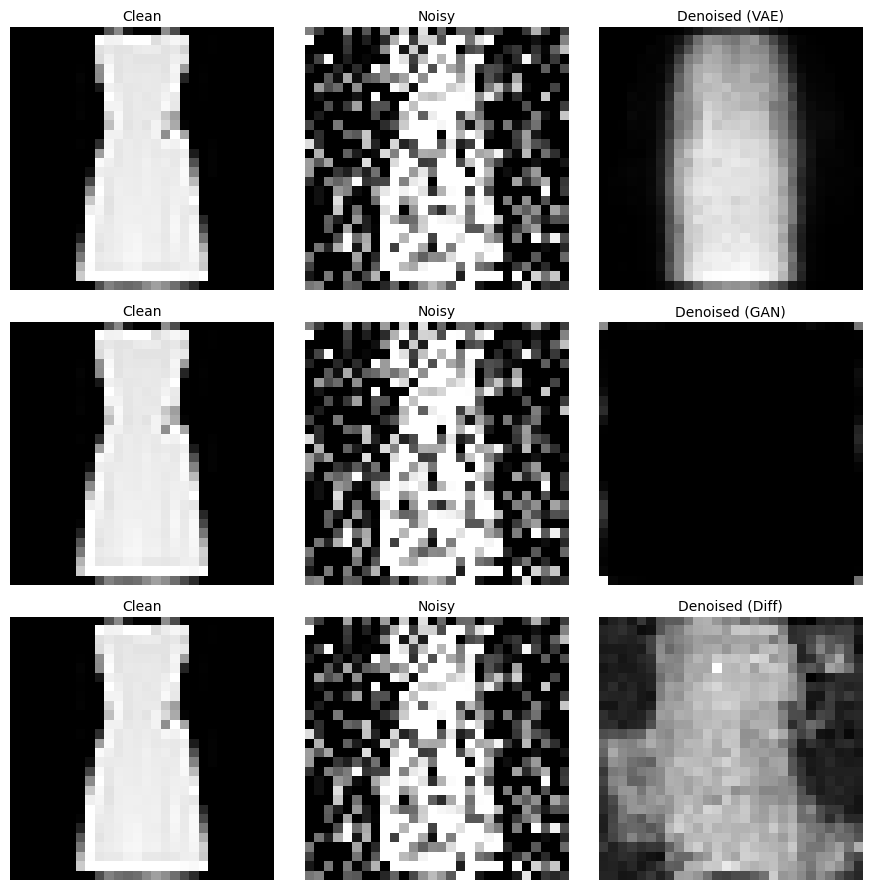

In [ ]:
# Pick a single image
clean, _ = ds_val[0]
clean = clean.unsqueeze(0).to(device)
noisy = add_noise(clean)

vae.eval(); gen.eval(); diffusion.eval()

with torch.no_grad():
    denoise_vae, _, _ = vae(noisy)
    denoise_gan = gen(noisy)
    denoise_diff = diffusion.denoise(noisy)

# Convert to cpu numpy for plotting
imgs = [clean, noisy, denoise_vae, clean, noisy, denoise_gan, clean, noisy, denoise_diff]
imgs = [img.squeeze().cpu().numpy() for img in imgs]

titles = [
    'Clean', 'Noisy', 'Denoised (VAE)',
    'Clean', 'Noisy', 'Denoised (GAN)',
    'Clean', 'Noisy', 'Denoised (Diff)'
]

fig, axes = plt.subplots(3, 3, figsize=(9, 9))

for ax, img, title in zip(axes.flat, imgs, titles):
    # If the image is a torch tensor, convert to NumPy
    if hasattr(img, "cpu"):
        img = img.cpu().numpy()
    # Add channel axis if needed (for grayscale images)
    if img.ndim == 2:
        ax.imshow(img, cmap="gray")
    else:
        ax.imshow(img)
    ax.set_title(title, fontsize=10, pad=4)
    ax.axis("off")

plt.tight_layout()
plt.show()